In [38]:
import pandas as pd

from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


import matplotlib.pyplot as plt

In [39]:
data = pd.read_csv('files/s.csv')
df = pd.DataFrame(data)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math_score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,190,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,200,78,75


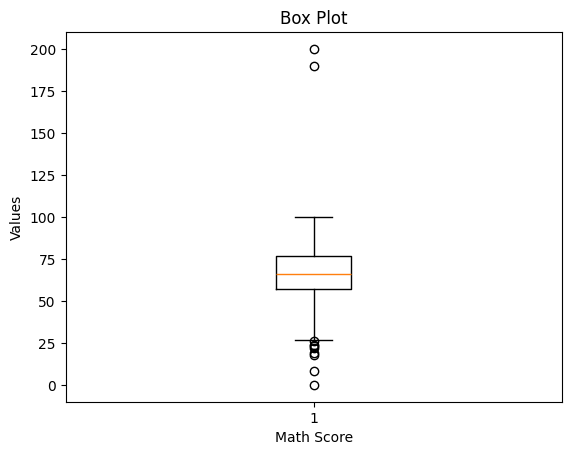

In [40]:
fig, ax = plt.subplots()
ax.boxplot(df['math_score'])
ax.set_title('Box Plot')
ax.set_xlabel('Math Score')
ax.set_ylabel('Values')
plt.show()

standard deviation

In [41]:
highest_allowed = df['math_score'].mean() + 3*df['math_score'].std()
lowest_allowed = df['math_score'].mean() - 3*df['math_score'].std()
print(highest_allowed, lowest_allowed)

114.99243852447015 17.675561475529854


In [42]:
df[(df['math_score'] > highest_allowed) | (df['math_score'] < lowest_allowed)]['math_score']

1      190
4      200
59       0
980      8
Name: math_score, dtype: int64

In [43]:
new = df[(df['math_score'] < highest_allowed) & (df['math_score'] > lowest_allowed)]
new.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math_score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92


iqr

In [44]:
percentile25 = df['math_score'].quantile(0.25)
percentile75 = df['math_score'].quantile(0.75)
iqr = percentile75 - percentile25

In [45]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print(upper_limit, lower_limit)

107.0 27.0


In [46]:
df[(df['math_score'] > upper_limit) | (df['math_score'] < lower_limit)]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math_score,reading score,writing score
1,female,group C,some college,standard,completed,190,90,88
4,male,group C,some college,standard,none,200,78,75
17,female,group B,some high school,free/reduced,none,18,32,28
59,female,group C,some high school,free/reduced,none,0,17,10
145,female,group C,some college,free/reduced,none,22,39,33
338,female,group B,some high school,free/reduced,none,24,38,27
466,female,group D,associate's degree,free/reduced,none,26,31,38
787,female,group B,some college,standard,none,19,38,32
842,female,group B,high school,free/reduced,completed,23,44,36
980,female,group B,high school,free/reduced,none,8,24,23


clustering

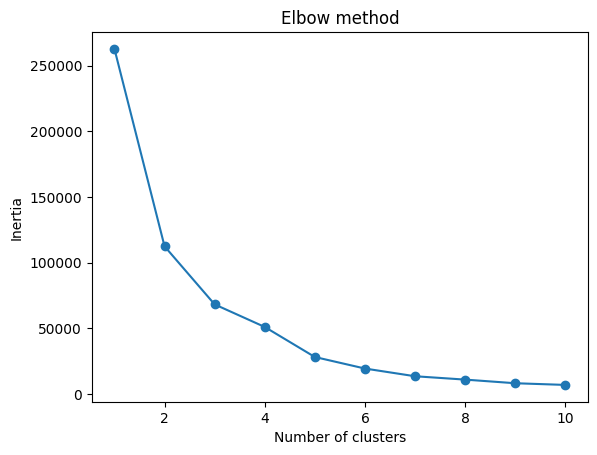

In [47]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[['math_score']])
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [48]:
db = KMeans(n_clusters=5, random_state=42)
df['cluster'] = db.fit_predict(df[['math_score']])

In [49]:
cluster_sizes = df['cluster'].value_counts()

outlier_cluster = cluster_sizes.idxmin() 
outliers = df[df['cluster'] == outlier_cluster]

outliers['math_score']

1    190
4    200
Name: math_score, dtype: int64

isolation forest

In [50]:
model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.01),random_state=42)
model.fit(df[['math_score']])

IsolationForest(contamination=0.01, random_state=42)

In [51]:
df['anomaly_score'] = model.decision_function(df[['math_score']])
df['anomaly'] = model.predict(df[['math_score']])
df['anomaly'].value_counts()

anomaly
 1    991
-1      9
Name: count, dtype: int64

In [52]:
df[df['anomaly']==-1]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math_score,reading score,writing score,cluster,anomaly_score,anomaly
1,female,group C,some college,standard,completed,190,90,88,4,-0.060414,-1
4,male,group C,some college,standard,none,200,78,75,4,-0.071157,-1
17,female,group B,some high school,free/reduced,none,18,32,28,3,-0.067567,-1
59,female,group C,some high school,free/reduced,none,0,17,10,3,-0.113131,-1
145,female,group C,some college,free/reduced,none,22,39,33,3,-0.032804,-1
338,female,group B,some high school,free/reduced,none,24,38,27,3,-0.007626,-1
787,female,group B,some college,standard,none,19,38,32,3,-0.061994,-1
842,female,group B,high school,free/reduced,completed,23,44,36,3,-0.027008,-1
980,female,group B,high school,free/reduced,none,8,24,23,3,-0.102418,-1


lof

In [53]:
lof = LocalOutlierFactor(n_neighbors=100, contamination=0.01)
df['lof-anomaly'] = lof.fit_predict(df[['math_score']])
df['lof-anomaly'].value_counts()

lof-anomaly
 1    990
-1     10
Name: count, dtype: int64

In [54]:
df[df['lof-anomaly']==-1].math_score

1      190
4      200
17      18
59       0
145     22
338     24
466     26
787     19
842     23
980      8
Name: math_score, dtype: int64